#### **Install Packages**

In [1]:
# %%capture
# !pip install pandas numpy matplotlib scikit-image tqdm gdown opencv-python plotly pillow scikit-learn
# !pip install nbformat --upgrade
!pip install --upgrade jupyter ipywidgets

#### **Import modules**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import skimage.io as skio
from skimage.color import rgb2gray, rgba2rgb, hsv2rgb
from tqdm.notebook import tqdm as tqdm
from skimage.transform import resize
import os
import gdown
import cv2

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from PIL import Image


#### **Prepare file**

#### **Load Images**

In [3]:
def glob_filepath(folder, ext, subfolder=False):
    """
    Get all the filepaths of a folder with a given extension without case sensitivity
    Args: folder -> the folder to search
          ext -> the extension of the files to search for
          subfolder -> whether to include subfolders in the search
    Return: list of filepaths
    """
    filepath = []

    if folder[-1] != '/' and folder != '':
        folder += '/'

    if not isinstance(ext, list):
        ext = [ext]

    if subfolder:
        folder = os.path.join(folder, '**')

    for item in ext:
        # Using glob with case-insensitive patterns
        filepath += glob(os.path.join(folder, '*.' + item), recursive=subfolder)
        filepath += glob(os.path.join(folder, '*.' + item.upper()), recursive=subfolder)
        filepath += glob(os.path.join(folder, '*.' + item.lower()), recursive=subfolder)
    
    return sorted(list(set(filepath)))


In [4]:

filepaths = glob_filepath(folder='../data/data_v1', ext=['jpg', 'png', 'jpeg'], subfolder=True)
print(filepaths)

['../data/data_v1/pistachio24_BACK(1) (1).JPG', '../data/data_v1/pistachio24_BACK(1) (1).png', '../data/data_v1/pistachio24_BACK(1).JPG', '../data/data_v1/pistachio24_BACK(2).JPG', '../data/data_v1/pistachio24_FRONT(1).JPG', '../data/data_v1/pistachio24_FRONT(2).JPG', '../data/data_v1/pistachio24_FRONT(3).JPG']


In [5]:
def read_image(filepath, show_image=True, return_arr=True):
  try:
    img = skio.imread(filepath)
    if show_image:
      skio.imshow(img)
  except:
    img = Image.open(filepaths[0])
    img_arr = np.array(img)
    if show_image:
      display(img)
    img = img_arr
  if return_arr:
    return(img)



#### **Load Sample Image**

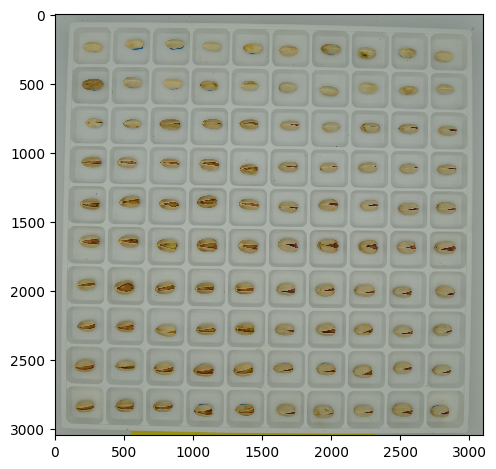

In [6]:
img = read_image(filepath=filepaths[0], show_image=True, return_arr=True)
fig = px.imshow(img)

##### **Crop out Pistachios**

In [7]:
def sort_contours(contours, y_overlap_threshold=2, sort_by_topmost=False):
    # Group contours into rows based on y-coordinate overlap
    def group_into_rows(contours):
        rows = []
        current_row = [contours[0]]
        for contour in contours[1:]:
            _, current_y, _, current_h = cv2.boundingRect(current_row[-1])
            _, next_y, _, next_h = cv2.boundingRect(contour)
            
            # Check if the contour belongs to the current row
            if min(current_y + current_h, next_y + next_h) - max(current_y, next_y) > y_overlap_threshold:
                current_row.append(contour)
            else:
                rows.append(current_row)
                current_row = [contour]
        
        rows.append(current_row)
        return rows

    # Sort contours in each row based on x-coordinate
    def sort_row(row):
        return sorted(row, key=lambda contour: cv2.boundingRect(contour)[0])

    if sort_by_topmost:
        # Sort contours based on the top y-coordinate
        sorted_contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[1])
    else:
        # First group contours into rows, then sort each row
        contours.sort(key=lambda contour: cv2.boundingRect(contour)[1]) # Sort by top y-coordinate
        rows = group_into_rows(contours)
        sorted_contours = [contour for row in rows for contour in sort_row(row)]

    return sorted_contours


In [8]:
from copy import deepcopy

import shutil

from sklearn.cluster import DBSCAN

def get_valid_contours(contours):
    """
    Separate valid and invalid contours based on their sizes.

    Parameters:
    contours (list): A list of contours to be separated.

    Returns:
    tuple: A tuple containing two lists: valid_contours and invalid_contours.
    """

    areas = []
    valid_contours = []
    invalid_contours = []

    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)
        areas.append([w, h]) 

    areas_np = np.array(areas)

    db = DBSCAN(eps=0.5, min_samples=2, metric='euclidean').fit(areas_np)
    labels = db.labels_

    # Separate the contours based on the clustering
    for i, label in enumerate(labels):
        if label == -1:  # DBSCAN labels noise (outliers) as -1, assuming noise points are invalid contours
            invalid_contours.append(contours[i])
        else:
            valid_contours.append(contours[i])

    return valid_contours, invalid_contours

In [9]:

from sklearn.decomposition import PCA

def fit_pca(coordinates, n_components=2, pt1=None, pt2=None):
    pca_cord = pd.DataFrame(coordinates, columns=['y', 'x'])
    pca = PCA(n_components=n_components)
    pca.fit(coordinates)
    pca_coordinates = pca.transform(coordinates)
    pca_cord['pca_y'] = pca_coordinates[:, 0]
    pca_cord['pca_x'] = pca_coordinates[:, 1]

    points_pd = []
    for points in [pt1, pt2]:
        if points is not None:
            points = np.array(points)
            pca_cord_array = pca_cord[['y', 'x']].to_numpy()
            matches = np.all(pca_cord_array[:, None] == points, axis=2)
            mask = np.any(matches, axis=1)
            selected_points = pca_cord[mask]
            points_pd.append(selected_points)
    points_pd = pd.concat(points_pd).reset_index(drop=True)
    tip_pd = points_pd.loc[points_pd['pca_y'].idxmax()]
    point = tip_pd[['y', 'x']].astype('int').values.tolist()
    return point

def distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
def find_extreme_points(coordinates):
    
    hull = cv2.convexHull(coordinates)

    # Function to calculate distance

    # Initialize maximum distance and corresponding points
    max_distance = 0
    point1 = None
    point2 = None

    # Iterate over all edges of the convex hull
    for i in range(len(hull)):
        for j in range(len(hull)):
            dist = distance(hull[i][0], hull[j][0])
            if dist > max_distance:
                max_distance = dist
                point1 = hull[i][0]
                point2 = hull[j][0]

    return point1, point2

In [10]:
def convert_to_png(filename, white_balance, show_image=False):

    if 'png' not in filename:
        print(f"Converting {filename} to png")
        filename_not_png = filename
        filename = filename.replace(os.path.splitext(filename)[1], '.png')
        Image.open(filename_not_png).save(filename)

    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    
    if white_balance:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        avg_a = np.average(image[:, :, 1])
        avg_b = np.average(image[:, :, 2])
        image[:, :, 1] = image[:, :, 1] - ((avg_a - 128) * (image[:, :, 0] / 255.0) * 1.1)
        image[:, :, 2] = image[:, :, 2] - ((avg_b - 128) * (image[:, :, 0] / 255.0) * 1.1)
        image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    if show_image:
        skio.imshow(image)
        print(filename)
    return(image, filename)

In [11]:
def extract_pistachio_from_plate(filepath, adaptive_thresh=False, sorted_contours=True,
                                  cnt_width=100, cnt_height=50, white_balance=False, 
                                  padding=True, padding_percentage=5, save=True, show_image=False,
                                  sort_by_topmost=False, y_overlap_threshold=20,
                                  print_details=False, metadata=None):
    # Load the image
    filepath_backup = filepath 
    image, image_path = convert_to_png(filepath, white_balance) # replace with your image file path
    # image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)#

    if image.shape[2] < 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

    image_copy, image_backup =  deepcopy(image), deepcopy(image)
    bgr = image[:,:,:3]
    folder_dir = os.path.dirname(image_path).replace('unprocessed', 'processed')

    filename = '.'.join(os.path.basename(image_path).split('.')[:-1])
    folder_dir = os.path.join(folder_dir, filename)
    if os.path.isdir(folder_dir):
        shutil.rmtree(folder_dir)
        
    print(f"Artefact will be saved in {folder_dir}")
    os.makedirs(folder_dir, exist_ok=True)


    # Convert to grayscale for processing
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    if adaptive_thresh:
        # Adaptive Thresholding (useful if lighting is uneven)
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    else:
        # Thresholding
        _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)


    # Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # indexed_image = skio.imread(image_path) # To draw indexed contours
    indx = 1

    # val_cnt, inval_cnt = get_valid_contours(contours)
    valid_contours = []
    # contours = val_cnt
    for idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if w > cnt_width and h > cnt_height:  
            if print_details:
                print(f"indx: {indx}, id: {idx}, x: {x}, y: {y}, w: {w}, h: {h}, width: {cnt_width}, height: {cnt_height}")
            valid_contours.append(contour)
            indx += 1
    
    if sorted_contours:
        valid_contours = sort_contours(valid_contours,y_overlap_threshold=y_overlap_threshold, sort_by_topmost=sort_by_topmost)

    
    # Initialize an array to store the pistachio indices
    height, width, _ = image.shape
    pistachio_indices = np.full((height, width), None)
    tip_indices = np.full((height, width), None)
    tip_list = []
    
    indx = 1
    for idx, contour in tqdm(enumerate(valid_contours), desc='Processing contours', total=len(valid_contours)):
        # Mark the pixels belonging to this pistachio
        # Step 1: Create a blank mask
        x, y, w, h = cv2.boundingRect(contour)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # Step 2: Draw the contour on the mask
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        
        # Step 3: Use the mask to set the indx values only for the pixels inside the contour
        pistachio_indices[mask == 255] = indx

        coordinates = np.column_stack(np.where(mask == 255))

        point1, point2 = find_extreme_points(coordinates)
        point = fit_pca(coordinates, n_components=2, pt1=point1, pt2=point2)
        
        tip_list.append(point)


        # tip_indices[point[1], point[0]] = 'Tip'
        # print(f"indx: {indx}, id: {idx}, point: {point}")
        # pistachio_indices[point[1], point[0]] = indx

        # Step 4: Extract the image containing only the pixels inside the contour
        pistachio = cv2.bitwise_and(image, image, mask=mask)

        processed_img = pistachio[:,:,:3]
        alpha = pistachio[:,:,3] # Channel 3
        pistachio = np.dstack([processed_img, alpha]) # Add the alpha channel
        pistachio = pistachio[y:y+h, x:x+w]
        if save:
            cv2.imwrite(f"{os.path.join(folder_dir, 'pistachio_'+str(indx)+'.png')}", pistachio)

        indx += 1

    mask = np.zeros(image_copy.shape, dtype="uint8")

    # Draw the valid contours on the mask with opaque alpha (255)
    # cv2.drawContours(mask, valid_contours, -1, (255, 255, 255, 255), -1)  # Note the -1 thickness to fill the contour
    cv2.drawContours(mask, valid_contours, -1, (255, 255, 255, 255), -1)  # Note the -1 thickness to fill the contour

    # Apply the mask to the image: wherever the mask is opaque, we retain the original image, 
    # and wherever the mask is transparent, we set the image to transparent
    image = cv2.bitwise_and(image_copy, mask)

    if padding:
        pad_width = max(image.shape) // (100 // padding_percentage)
        print(f"Padding image with pad_width: {pad_width}")
        pad_width_tuple = ((pad_width, pad_width), (pad_width, pad_width), (0, 0))  # No padding for channels
        padded_image = np.pad(image, pad_width_tuple, mode='constant', constant_values=255)
    else:
        padded_image = image.copy()

    indx = 1
    if metadata is not None:
        metadata_ = metadata.copy()
        metadata_ = metadata_.loc[metadata_.Filepath==filepath_backup, ['Filepath', 'Nut Numbering', 'Kernel Status']]

    for idx, contour in enumerate(valid_contours):
        x, y, w, h = cv2.boundingRect(contour)
        # Adjust x and y with pad_width to account for the padding
        x_padded = x + pad_width
        y_padded = y + pad_width
        # Draw text at the new padded coordinates
        try:
            kernel_status = metadata_.loc[metadata_['Nut Numbering']==indx, 'Kernel Status'].values[0]
        except:
            kernel_status = 'Unknown'
        cv2.putText(padded_image, str(indx) + ', ' + kernel_status, (x_padded, y_padded - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0, 255), 2, cv2.LINE_AA)
        point = tip_list[idx]

        tip_indices[point[0], point[1]] = 'Tip'
        pistachio_indices[point[0], point[1]] = indx

        cv2.circle(padded_image, np.array(point[::-1]) + pad_width, 5, (0, 0, 255, 255), -1)
        indx += 1

    file_ext = image_path.split('.')[-1]
    if save:
        cv2.imwrite(f"{os.path.join(folder_dir, filename + '_processed' + '.' + file_ext)}", padded_image)

    data = {
        'Row': np.repeat(np.arange(height), width),
        'Col': np.tile(np.arange(width), height),
        'Red': image_backup[..., 2].flatten(),
        'Green': image_backup[..., 1].flatten(),
        'Blue': image_backup[..., 0].flatten(),
        'Pistachio_Index': pistachio_indices.flatten(),
        'Tip': tip_indices.flatten()
    }
    if show_image:
        if save:
            skio.imshow(skio.imread(f"{os.path.join(folder_dir, filename+ '_processed' + '.' + file_ext)}"))
        else:
            skio.imshow(padded_image)

    df = pd.DataFrame(data)
    mask = (df[['Red', 'Green', 'Blue']] == 0).all(axis=1)
    df.loc[mask, ['Red', 'Green', 'Blue']] = 255

    return df

In [12]:
def extract_pistachio_from_plate(filepath, adaptive_thresh=False, sorted_contours=True,
                                  cnt_width=100, cnt_height=50, white_balance=False, 
                                  padding=True, padding_percentage=5, save=True, show_image=False,
                                  sort_by_topmost=False, y_overlap_threshold=20,
                                  print_details=False, metadata=None):
    # Load the image
    filepath_backup = filepath 
    image, image_path = convert_to_png(filepath, white_balance) # replace with your image file path
    # image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)#

    if image.shape[2] < 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

    image_copy, image_backup =  deepcopy(image), deepcopy(image)
    bgr = image[:,:,:3]
    folder_dir = os.path.dirname(image_path).replace('unprocessed', 'processed')

    filename = '.'.join(os.path.basename(image_path).split('.')[:-1])
    folder_dir = os.path.join(folder_dir, filename)
    if os.path.isdir(folder_dir):
        shutil.rmtree(folder_dir)
        
    print(f"Artefact will be saved in {folder_dir}")
    os.makedirs(folder_dir, exist_ok=True)


    # Convert to grayscale for processing
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    if adaptive_thresh:
        # Adaptive Thresholding (useful if lighting is uneven)
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    else:
        # Thresholding
        _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)


    # Find Contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # indexed_image = skio.imread(image_path) # To draw indexed contours
    indx = 1

    # val_cnt, inval_cnt = get_valid_contours(contours)
    valid_contours = []
    # contours = val_cnt
    for idx, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if w > cnt_width and h > cnt_height:  
            if print_details:
                print(f"indx: {indx}, id: {idx}, x: {x}, y: {y}, w: {w}, h: {h}, width: {cnt_width}, height: {cnt_height}")
            valid_contours.append(contour)
            indx += 1
    
    if sorted_contours:
        valid_contours = sort_contours(valid_contours,y_overlap_threshold=y_overlap_threshold, sort_by_topmost=sort_by_topmost)

    # Initialize an array to store the pistachio indices
    height, width, _ = image.shape
    pistachio_indices = np.full((height, width), None)
    tip_indices = np.full((height, width), None)
    tip_list = []
    
    indx = 1
    for idx, contour in tqdm(enumerate(valid_contours), desc='Processing contours', total=len(valid_contours)):
        # Mark the pixels belonging to this pistachio
        # Step 1: Create a blank mask
        x, y, w, h = cv2.boundingRect(contour)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # Step 2: Draw the contour on the mask
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        
        # Step 3: Use the mask to set the indx values only for the pixels inside the contour
        pistachio_indices[mask == 255] = indx

        coordinates = np.column_stack(np.where(mask == 255))

        point1, point2 = find_extreme_points(coordinates)
        point = fit_pca(coordinates, n_components=2, pt1=point1, pt2=point2)
        
        tip_list.append(point)


        # tip_indices[point[1], point[0]] = 'Tip'
        # print(f"indx: {indx}, id: {idx}, point: {point}")
        # pistachio_indices[point[1], point[0]] = indx

        # Step 4: Extract the image containing only the pixels inside the contour
        pistachio = cv2.bitwise_and(image, image, mask=mask)

        processed_img = pistachio[:,:,:3]
        alpha = pistachio[:,:,3] # Channel 3
        pistachio = np.dstack([processed_img, alpha]) # Add the alpha channel
        pistachio = pistachio[y:y+h, x:x+w]
        if save:
            cv2.imwrite(f"{os.path.join(folder_dir, 'pistachio_'+str(indx)+'.png')}", pistachio)

        indx += 1

    mask = np.zeros(image_copy.shape, dtype="uint8")

    # Draw the valid contours on the mask with opaque alpha (255)
    cv2.drawContours(mask, valid_contours, -1, (255, 255, 255, 255), -1)  # Note the -1 thickness to fill the contour

    # Apply the mask to the image: wherever the mask is opaque, we retain the original image, 
    # and wherever the mask is transparent, we set the image to transparent
    image = cv2.bitwise_and(image_copy, mask)

    if padding:
        pad_width = max(image.shape) // (100 // padding_percentage)
        print(f"Padding image with pad_width: {pad_width}")
        pad_width_tuple = ((pad_width, pad_width), (pad_width, pad_width), (0, 0))  # No padding for channels
        padded_image = np.pad(image, pad_width_tuple, mode='constant', constant_values=255)
    else:
        padded_image = image.copy()


    indx = 1
    
    for idx, contour in enumerate(valid_contours):
        x, y, w, h = cv2.boundingRect(contour)
        # Adjust x and y with pad_width to account for the padding
        x_padded = x + pad_width
        y_padded = y + pad_width
        point = tip_list[idx]
        pistachio_indices[point[0], point[1]] = indx

        cv2.circle(padded_image, np.array(point[::-1]) + pad_width, 5, (0, 0, 255, 255), -1)

        indx += 1
    skio.imshow(padded_image)
    file_ext = image_path.split('.')[-1]
    if save:
        cv2.imwrite(f"{os.path.join(folder_dir, filename + '_processed' + '.' + file_ext)}", padded_image)
        print(f"Processed img saved in {os.path.join(folder_dir, filename + '_processed' + '.' + file_ext)}")
    # data = {
    #     'Row': np.repeat(np.arange(height), width),
    #     'Col': np.tile(np.arange(width), height),
    #     'Red': image_backup[..., 2].flatten(),
    #     'Green': image_backup[..., 1].flatten(),
    #     'Blue': image_backup[..., 0].flatten(),
    #     'Pistachio_Index': pistachio_indices.flatten(),
    #     'Tip': tip_indices.flatten()
    # }
    # if show_image:
    #     if save:
    #         skio.imshow(skio.imread(f"{os.path.join(folder_dir, filename+ '_processed' + '.' + file_ext)}"))
    #     else:
    #         skio.imshow(padded_image)

    # df = pd.DataFrame(data)
    # mask = (df[['Red', 'Green', 'Blue']] == 0).all(axis=1)
    # df.loc[mask, ['Red', 'Green', 'Blue']] = 255

    # return df

Converting ../data/data_v1/pistachio24_BACK(1) (1).JPG to png


Artefact will be saved in ../data/data_v1/pistachio24_BACK(1) (1)


Processing contours:   0%|          | 0/16 [00:00<?, ?it/s]

Padding image with pad_width: 310


/home/qoma/pistachio-opening/.venv/lib64/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning:

Low image data range; displaying image with stretched contrast.



Processed img saved in ../data/data_v1/pistachio24_BACK(1) (1)/pistachio24_BACK(1) (1)_processed.png


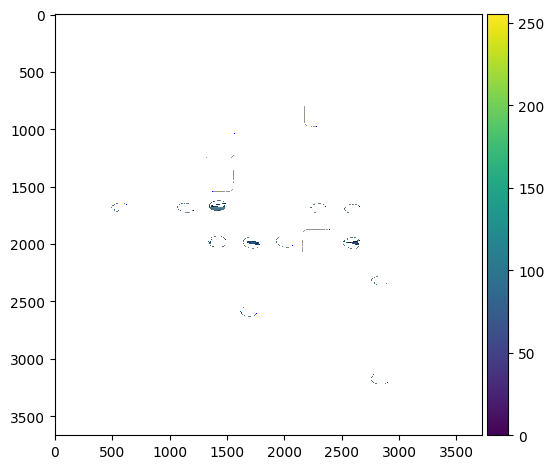

In [13]:
# 0, 3, 5, 7, 9.
extract_pistachio_from_plate(filepaths[0], cnt_width=80, cnt_height=80, 
                            adaptive_thresh=True, save=True, y_overlap_threshold=20,
                            sort_by_topmost=True, padding_percentage=10, white_balance=True,
                            print_details=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 22.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 22.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 22.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 21.8 MB/s eta 0:00:00


In [33]:

def points_to_tip(df, percentage, closest=True):
    # Function to calculate Euclidean distance
    def euclidean_distance(point1, point2):
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    if closest:
        closest_or_farthest = 'Closest'
    else:
        closest_or_farthest = 'Farthest'
    df[f'{closest_or_farthest}_{percentage}'] = None

    for pistachio_index, group in tqdm(df.groupby('Pistachio_Index'), desc='Tip neighborhood', total=len(df.groupby('Pistachio_Index'))):
        # Extract the tip coordinates for the current group
        tip_coords = group[group['Tip'] == 'Tip'][['Col', 'Row']].values
        if len(tip_coords) > 0:
            tip_coords = tip_coords[0]

            # Calculate distance of each point in the group to the tip
            distances = group.apply(lambda row: euclidean_distance((row['Col'], row['Row']), tip_coords), axis=1)

            # Determine the threshold distance
            if closest:
                threshold_distance = np.percentile(distances, percentage)
                # Update the Neighborhood column for closest points
                df.loc[group.index, f'{closest_or_farthest}_{percentage}'] = [True if x <= threshold_distance else None for x in distances]
            else:
                threshold_distance = np.percentile(distances, 100 - percentage)
                # Update the Neighborhood column for farthest points
                df.loc[group.index, f'{closest_or_farthest}_{percentage}'] = [True if x >= threshold_distance else None for x in distances]

    return df


##### **Major Color Analysis for Pistachio Progression (Transparent Image)**

##### **Critical point**

In [ ]:

filepaths = glob_filepath(folder='../data/image/', ext=['jpg', 'png', 'jpeg'])

print(filepaths)

In [ ]:
filepaths = glob_filepath(folder='../data/image/unprocessed_images/2022_Golden_Hills', ext=['jpg', 'jpeg'])
filepaths = [filepath for filepath in filepaths if 'full' in filepath]
print(filepaths)
print(len(filepaths))

metadata_filepaths = glob_filepath(folder='../data/image/unprocessed_images/2022_Golden_Hills', ext=['xlsx'])
print(metadata_filepaths)
print(len(metadata_filepaths))

In [ ]:
metadata = pd.read_excel(metadata_filepaths[-1])
valid_metadata_columns = ['Timepoint',	'Cluster',	'Nut Numbering',	'Photo Name', 'Kernel Status']
metadata = metadata[valid_metadata_columns]
print(metadata['Photo Name'].drop_duplicates().values.tolist())
print(len(metadata['Photo Name'].drop_duplicates().values.tolist()))
filepaths_ = pd.DataFrame(filepaths, columns=['Filepath'])
filepaths_['Photo Name'] = filepaths_['Filepath'].apply(lambda x: os.path.basename(x))
metadata = metadata.merge(filepaths_, on='Photo Name', how='left').dropna(subset=['Filepath'])
display(metadata)

In [ ]:
img_filepaths = metadata['Filepath'].drop_duplicates().values.tolist()
display(img_filepaths)
print(len(img_filepaths))

In [ ]:
# tip_neighborhood, tip_percentage, closest = True, 30, True

# if closest:
#     closest_or_farthest = 'Closest'
# else:
#     closest_or_farthest = 'Farthest'

# for img_filepath in tqdm(img_filepaths, desc='Processing images'):
#     img_filepath = img_filepath
#     print(f'img_filepath: {img_filepath}')
#     full_plate_df = extract_pistachio_from_plate(f'{img_filepath}',
#                                               cnt_width=80, cnt_height=80, adaptive_thresh=False, save=True,
#                                               y_overlap_threshold=20, sort_by_topmost=True, metadata=metadata,
#                                                padding_percentage=10, white_balance=True, print_details=False)
#     if tip_neighborhood:
#         full_plate_df = points_to_tip(full_plate_df, tip_percentage)
    
# full_plate_df_backup = full_plate_df.copy(deep=True)
# display(full_plate_df.head())
# print("\n\n=================================\n\n")
# display(pd.DataFrame(full_plate_df['Pistachio_Index'].value_counts()).sort_index())
# display(f"Total pistachio pixel: {full_plate_df['Pistachio_Index'].value_counts().sum()}")

In [117]:
tip_neighborhood, tip_percentage, closest = False, 30, True

if closest:
    closest_or_farthest = 'Closest'
else:
    closest_or_farthest = 'Farthest'

# for img_filepath in tqdm(img_filepaths, desc='Processing images'):
img_filepath = '../data/image/unprocessed_images/2022_Golden_Hills/CT1-A5-full.jpg'
print(f'img_filepath: {img_filepath}')
full_plate_df = extract_pistachio_from_plate(f'{img_filepath}',
                                            cnt_width=80, cnt_height=80, adaptive_thresh=False, save=True,
                                            y_overlap_threshold=20, sort_by_topmost=True, metadata=metadata,
                                            padding_percentage=10, white_balance=True, print_details=False)
if tip_neighborhood:
    full_plate_df = points_to_tip(full_plate_df, tip_percentage, closest)
    
full_plate_df_backup = full_plate_df.copy(deep=True)
display(full_plate_df.head())
print("\n\n=================================\n\n")
display(pd.DataFrame(full_plate_df['Pistachio_Index'].value_counts()).sort_index())
display(f"Total pistachio pixel: {full_plate_df['Pistachio_Index'].value_counts().sum()}")

img_filepath: ../data/image/unprocessed_images/2022_Golden_Hills/CT1-A5-full.jpg
Converting ../data/image/unprocessed_images/2022_Golden_Hills/CT1-A5-full.jpg to png
Artefact will be saved in ../data/image/processed_images/2022_Golden_Hills/CT1-A5-full


Processing contours:   0%|          | 0/30 [00:00<?, ?it/s]

Padding image with pad_width: 313


,Row,Col,Red,Green,Blue,Pistachio_Index,Tip
0,0,0,210,217,223,None,None
1,0,1,210,217,223,None,None
2,0,2,209,217,225,None,None
3,0,3,209,217,225,None,None
4,0,4,209,217,225,None,None


,Pistachio_Index
1,27449
2,29456
3,19134
4,24895
5,27586
6,29889
7,30441
8,23771
9,21620
10,24556


'Total pistachio pixel: 774518'

In [118]:
full_plate_df[full_plate_df.Tip == 'Tip'].sort_values(by=['Pistachio_Index'])

,Row,Col,Red,Green,Blue,Pistachio_Index,Tip
277322,88,1266,212,191,182,1,Tip
578948,184,1740,211,197,172,2,Tip
728507,232,723,208,194,162,3,Tip
740640,236,308,211,191,165,4,Tip
1526849,486,2267,218,199,170,5,Tip
1138214,362,2620,227,201,166,6,Tip
2040202,650,1152,221,201,160,7,Tip
2100438,669,1785,211,192,175,8,Tip
2838188,904,2340,202,192,157,9,Tip
2296967,732,683,222,204,185,10,Tip


#### **Analysis**

#### **Axis mask**

In [119]:
def axis_mask(val, base):
    """
    Construct sliding kernel for centers based on cube dimension i.e base
    """
    if val == 0:
        inf_mask = 0
        sup_mask = base
    elif val == base:
        inf_mask = 0
        sup_mask = base
    elif val % base == 0:
        inf_mask = val - base
        sup_mask = val
    else:
        inf_mask = base * np.floor(val/base) # closest mulitple of
        sup_mask = base * np.ceil(val/base)
    return((int(inf_mask), int(sup_mask)))


def get_bounding_cubes(data, step = 3):
    """
    Get centers using mask
    """
    data_masks = []
    mask_center = []
    for pos, row in tqdm(enumerate(data), total=len(data), desc='Processing rows'):
        x_mask = axis_mask(val=row[0], base=step )
        y_mask = axis_mask(val=row[1], base=step )
        z_mask = axis_mask(val=row[2], base=step)
        center_x = np.median(range(x_mask[0], x_mask[1] + 1))
        center_y = np.median(range(y_mask[0], y_mask[1] + 1))
        center_z = np.median(range(z_mask[0], z_mask[1] + 1))
        data_masks.append((x_mask,y_mask, z_mask))
        mask_center.append((int(center_x), int(center_y), int(center_z)))

    return(data, data_masks, mask_center)

def make_center_df(df, cols=[], cube_width = 3):
    """
    Return dataframe of image representing the RGB of reduced dimension (i.e using centers)
    """
    if not isinstance(cols, list):
        raise Exception("cols must be a list of columns from the dataframe")
    if len(cols) < 1:
        cols = df.columns
        df_ = df.copy()
    else:
        df_ = df.copy()
        df_ = df_[cols]


    boxes = get_bounding_cubes(df_.values, step = cube_width)
    center_df = pd.DataFrame(boxes[2])
    center_df.columns = [col + ' center' for col in df_.columns]
    res = pd.concat([df.reset_index(drop=True), center_df], axis=1)
    return(res)

In [120]:
full_plate_df = full_plate_df_backup.copy(deep=True)

In [121]:
full_plate_df_within_contour = full_plate_df.dropna(subset=['Pistachio_Index'])
print(full_plate_df_within_contour.shape, full_plate_df_backup.shape)
display(full_plate_df_within_contour)

(774518, 7) (7946021, 7)


,Row,Col,Red,Green,Blue,Pistachio_Index,Tip
277322,88,1266,212,191,182,1,Tip
277323,88,1267,201,181,168,1,None
277324,88,1268,201,180,158,1,None
277325,88,1269,199,181,152,1,None
277326,88,1270,198,181,156,1,None
...,...,...,...,...,...,...,...
7467422,2380,1362,216,197,188,29,Tip
7467423,2380,1363,214,194,187,29,None
7467424,2380,1364,199,179,173,29,None
7467425,2380,1365,195,178,170,29,None


In [122]:
full_plate_df_within_contour = make_center_df(full_plate_df_within_contour, cols=['Red', 'Green', 'Blue'], cube_width=10)
full_plate_df_within_contour

Processing rows:   0%|          | 0/774518 [00:00<?, ?it/s]

,Row,Col,Red,Green,Blue,Pistachio_Index,Tip,Red center,Green center,Blue center
0,88,1266,212,191,182,1,Tip,215,195,185
1,88,1267,201,181,168,1,None,205,185,165
2,88,1268,201,180,158,1,None,205,175,155
3,88,1269,199,181,152,1,None,195,185,155
4,88,1270,198,181,156,1,None,195,185,155
...,...,...,...,...,...,...,...,...,...,...
774513,2380,1362,216,197,188,29,Tip,215,195,185
774514,2380,1363,214,194,187,29,None,215,195,185
774515,2380,1364,199,179,173,29,None,195,175,175
774516,2380,1365,195,178,170,29,None,195,175,165


In [123]:
result_dir = '../result/xlsx'
img_filepath_basename, ext = os.path.splitext(os.path.basename(img_filepath))
if tip_neighborhood:
    img_filepath_basename = os.path.join(img_filepath_basename, f'tip_{closest_or_farthest}_{tip_percentage}')
else:
    img_filepath_basename = os.path.join(img_filepath_basename, f'full')
result_filepath = os.path.join(result_dir, img_filepath_basename, "within_contour_df.csv")
os.makedirs(os.path.dirname(result_filepath), exist_ok=True)
full_plate_df_within_contour.to_csv(result_filepath, index=False)
print(f"Saved result to {result_filepath}")
display(full_plate_df_within_contour)

Saved result to ../result/xlsx/CT1-A5-full/full/within_contour_df.csv


,Row,Col,Red,Green,Blue,Pistachio_Index,Tip,Red center,Green center,Blue center
0,88,1266,212,191,182,1,Tip,215,195,185
1,88,1267,201,181,168,1,None,205,185,165
2,88,1268,201,180,158,1,None,205,175,155
3,88,1269,199,181,152,1,None,195,185,155
4,88,1270,198,181,156,1,None,195,185,155
...,...,...,...,...,...,...,...,...,...,...
774513,2380,1362,216,197,188,29,Tip,215,195,185
774514,2380,1363,214,194,187,29,None,215,195,185
774515,2380,1364,199,179,173,29,None,195,175,175
774516,2380,1365,195,178,170,29,None,195,175,165


##### Read Pistachio Standard

In [124]:
pistachio_standard_df = pd.read_csv("../result/xlsx/standard pistachio/pistachio_standard_within_contour.csv")
print(pistachio_standard_df.shape)
pistachio_standard_dist = pistachio_standard_df[['Clusters','ClusterColor']].value_counts().to_frame().reset_index().rename(columns={0:'Count'})
pistachio_standard_dist['Percentage'] = (pistachio_standard_dist['Count'] / pistachio_standard_dist['Count'].sum()).round(3)
pistachio_standard_dist

(221672, 6)


,Clusters,ClusterColor,Count,Percentage
0,8,#c9b16d,63697,0.287
1,5,#b9a08d,60996,0.275
2,1,#dec99f,43891,0.198
3,0,#261d15,28100,0.127
4,6,#b39458,7864,0.035
5,4,#918473,6061,0.027
6,3,#736052,4589,0.021
7,2,#4f4233,3879,0.017
8,7,#9a6f4d,2595,0.012


In [125]:
pistachio_standard_df = pistachio_standard_df.drop_duplicates(subset=['Red center', 'Green center', 'Blue center'])
display(pistachio_standard_df)
print(pistachio_standard_df.shape)

full_data = full_plate_df_within_contour.merge(pistachio_standard_df, on=['Red center', 'Green center', 'Blue center'], how="left", suffixes=('', '_standard'))
assert full_data.shape[0] == full_plate_df_within_contour.shape[0]
display(full_data)
full_data_backup = full_data.copy(deep=True)

,Pistachio_Index,Red center,Green center,Blue center,Clusters,ClusterColor
0,1,5,5,5,0,#261d15
29,2,255,255,255,1,#dec99f
99,2,15,15,5,0,#261d15
133,1,15,5,5,0,#261d15
135,1,25,15,15,0,#261d15
...,...,...,...,...,...,...
218664,9,145,95,45,7,#9a6f4d
218917,6,165,145,75,6,#b39458
219280,6,215,165,95,8,#c9b16d
220288,6,95,85,45,2,#4f4233


(826, 6)


,Row,Col,Red,Green,Blue,Pistachio_Index,Tip,Red center,Green center,Blue center,Pistachio_Index_standard,Clusters,ClusterColor
0,88,1266,212,191,182,1,Tip,215,195,185,NaN,NaN,NaN
1,88,1267,201,181,168,1,None,205,185,165,6.0,1.0,#dec99f
2,88,1268,201,180,158,1,None,205,175,155,9.0,5.0,#b9a08d
3,88,1269,199,181,152,1,None,195,185,155,1.0,5.0,#b9a08d
4,88,1270,198,181,156,1,None,195,185,155,1.0,5.0,#b9a08d
...,...,...,...,...,...,...,...,...,...,...,...,...,...
774513,2380,1362,216,197,188,29,Tip,215,195,185,NaN,NaN,NaN
774514,2380,1363,214,194,187,29,None,215,195,185,NaN,NaN,NaN
774515,2380,1364,199,179,173,29,None,195,175,175,NaN,NaN,NaN
774516,2380,1365,195,178,170,29,None,195,175,165,9.0,1.0,#dec99f


In [126]:
full_data = full_data.dropna(subset=['Clusters']).reset_index(drop=True)
full_data['Clusters'] = full_data['Clusters'].astype('int')
full_data

,Row,Col,Red,Green,Blue,Pistachio_Index,Tip,Red center,Green center,Blue center,Pistachio_Index_standard,Clusters,ClusterColor
0,88,1267,201,181,168,1,None,205,185,165,6.0,1,#dec99f
1,88,1268,201,180,158,1,None,205,175,155,9.0,5,#b9a08d
2,88,1269,199,181,152,1,None,195,185,155,1.0,5,#b9a08d
3,88,1270,198,181,156,1,None,195,185,155,1.0,5,#b9a08d
4,88,1271,201,184,161,1,None,205,185,165,6.0,1,#dec99f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
769211,2379,1365,181,158,143,29,None,185,155,145,7.0,5,#b9a08d
769212,2379,1366,192,172,158,29,None,195,175,155,6.0,5,#b9a08d
769213,2379,1367,203,190,174,29,None,205,185,175,7.0,1,#dec99f
769214,2380,1365,195,178,170,29,None,195,175,165,9.0,1,#dec99f


In [127]:
if tip_neighborhood:
    full_data = full_data.dropna(subset=[f'{closest_or_farthest}_{tip_percentage}']).reset_index(drop=True)
    full_data

In [128]:
full_data_dist = full_data[['Clusters','ClusterColor']].value_counts().to_frame().reset_index().rename(columns={0:'Count'})
full_data_dist['Percentage'] = (full_data_dist['Count'] / full_data_dist['Count'].sum()).round(3)
full_data_dist = full_data_dist.merge(pistachio_standard_dist[['Clusters','ClusterColor']], on=['Clusters','ClusterColor'], how="right").fillna(0)
full_data_dist

,Clusters,ClusterColor,Count,Percentage
0,8,#c9b16d,673751.0,0.876
1,5,#b9a08d,48196.0,0.063
2,1,#dec99f,25817.0,0.034
3,0,#261d15,0.0,0.000
4,6,#b39458,20956.0,0.027
5,4,#918473,39.0,0.000
6,3,#736052,18.0,0.000
7,2,#4f4233,3.0,0.000
8,7,#9a6f4d,436.0,0.001


In [129]:
kernel_data = metadata.loc[metadata.Filepath == img_filepath, :].sort_values(by='Nut Numbering')[['Nut Numbering', 'Kernel Status']].rename(columns={'Nut Numbering': 'Pistachio_Index', 'Kernel Status': 'Status'})
kernel_data['Status Color'] = kernel_data['Status'].map({'Blank':'#dbc381', 'Filled':'#5dde6a'})
kernel_data

,Pistachio_Index,Status,Status Color
30,1,Blank,#dbc381
31,2,Filled,#5dde6a
32,3,Filled,#5dde6a
33,4,Filled,#5dde6a
34,5,Filled,#5dde6a
35,6,Filled,#5dde6a
36,7,Filled,#5dde6a
37,8,Filled,#5dde6a
38,9,Filled,#5dde6a
39,10,Filled,#5dde6a


In [130]:
full_data

,Row,Col,Red,Green,Blue,Pistachio_Index,Tip,Red center,Green center,Blue center,Pistachio_Index_standard,Clusters,ClusterColor
0,88,1267,201,181,168,1,None,205,185,165,6.0,1,#dec99f
1,88,1268,201,180,158,1,None,205,175,155,9.0,5,#b9a08d
2,88,1269,199,181,152,1,None,195,185,155,1.0,5,#b9a08d
3,88,1270,198,181,156,1,None,195,185,155,1.0,5,#b9a08d
4,88,1271,201,184,161,1,None,205,185,165,6.0,1,#dec99f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
769211,2379,1365,181,158,143,29,None,185,155,145,7.0,5,#b9a08d
769212,2379,1366,192,172,158,29,None,195,175,155,6.0,5,#b9a08d
769213,2379,1367,203,190,174,29,None,205,185,175,7.0,1,#dec99f
769214,2380,1365,195,178,170,29,None,195,175,165,9.0,1,#dec99f


In [131]:
full_data_percentages = full_data.groupby(['Pistachio_Index', 'Clusters'])['Clusters'].count().unstack().fillna(0)
full_data_percentages = full_data_percentages.div(full_data_percentages.sum(axis=1), axis=0).round(3).reset_index()
full_data_percentages = full_data_percentages.merge(kernel_data, on='Pistachio_Index')
full_data_percentages = full_data_percentages.set_index('Pistachio_Index')
missing_columns = set(pistachio_standard_dist['Clusters'].unique()) - set(full_data_percentages.columns)
for column in sorted(missing_columns):
    insert_position = 0
    for existing_col in full_data_percentages.columns:
        if int(existing_col) < column:
            insert_position += 1
        else:
            break
    full_data_percentages.insert(insert_position, str(column), float(0))
full_data_percentages

,0,1,2,3,4,5,6,7,8,Status,Status Color
Pistachio_Index,,,,,,,,,,,
1,0.0,0.021,0.0,0.000,0.0,0.073,0.003,0.001,0.902,Blank,#dbc381
2,0.0,0.019,0.0,0.000,0.0,0.051,0.002,0.000,0.927,Filled,#5dde6a
3,0.0,0.029,0.0,0.000,0.0,0.057,0.003,0.000,0.911,Filled,#5dde6a
4,0.0,0.045,0.0,0.000,0.0,0.062,0.002,0.001,0.890,Filled,#5dde6a
5,0.0,0.037,0.0,0.000,0.0,0.067,0.027,0.000,0.870,Filled,#5dde6a
6,0.0,0.046,0.0,0.000,0.0,0.056,0.007,0.001,0.891,Filled,#5dde6a
7,0.0,0.024,0.0,0.000,0.0,0.062,0.009,0.000,0.904,Filled,#5dde6a
8,0.0,0.025,0.0,0.000,0.0,0.049,0.006,0.000,0.919,Filled,#5dde6a
9,0.0,0.025,0.0,0.000,0.0,0.052,0.000,0.000,0.923,Filled,#5dde6a


In [132]:
result_dir = '../result/xlsx'
img_filepath_basename, ext = os.path.splitext(os.path.basename(img_filepath))
if tip_neighborhood:
    img_filepath_basename = os.path.join(img_filepath_basename, f'tip_{closest_or_farthest}_{tip_percentage}')
else:
    img_filepath_basename = os.path.join(img_filepath_basename, f'full')
result_filepath = os.path.join(result_dir, img_filepath_basename, "plate_percentages.csv")
os.makedirs(os.path.dirname(result_filepath), exist_ok=True)
full_data_percentages.to_csv(result_filepath)
print(f"Saved result to {result_filepath}")
# display(full_data_percentages)

Saved result to ../result/xlsx/CT1-A5-full/full/plate_percentages.csv
